# Overview of supervised classification algorithms

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## Dataset
For the examples, we are going to use the [**Recipe Ingredients Dataset**](https://www.kaggle.com/datasets/kaggle/recipe-ingredients-dataset).

Each recipe is a collection of ingredients and the task is to guess the kind of cuisine (multi-class classification).

First, we compute some statistics on the dataset in order to find the most specific ingredients for each type of cuisine.

In [34]:
import json
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [35]:
train_data_file = "/Users/flint/Data/recipe/kaggle_recipes/train.json"
with open(train_data_file, 'r') as infile:
    train_json = json.load(infile)

In [36]:
train_json[0]

{'id': 10259,
 'cuisine': 'greek',
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

In [37]:
def to_count_df(data, vectorizer, fit=True):
    y = [x['cuisine'] for x in data]
    documents = [x['ingredients'] for x in data]
    if fit:
        X = vectorizer.fit_transform(documents)
    else:
        X = vectorizer.transform(documents)
    return X, np.array(y)

In [38]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, token_pattern=None, lowercase=False, min_df=10)
X, y = to_count_df(train_json, vectorizer, fit=True)

In [39]:
X.shape

(39774, 2400)

### (optional) Simplify target

In [40]:
catmap = {'cajun_creole': 'usa', 'chinese': 'asian', 'filipino': 'asian', 
          'southern_us': 'usa', 'japanese': 'asian', 'korean': 'asian', 'thai': 'asian', 'vietnamese': 'asian'}

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [42]:
categories = list(set(y_train))

In [43]:
categories

['spanish',
 'indian',
 'irish',
 'chinese',
 'jamaican',
 'greek',
 'japanese',
 'filipino',
 'british',
 'southern_us',
 'italian',
 'cajun_creole',
 'mexican',
 'thai',
 'vietnamese',
 'russian',
 'brazilian',
 'french',
 'korean',
 'moroccan']

## Clustering example

In [44]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation

In [45]:
import matplotlib.pyplot as plt

In [46]:
from sklearn.decomposition import PCA
from collections import defaultdict

In [47]:
algorithms = {
    'kmeans': KMeans(n_clusters=len(categories), n_init='auto'),
    'hierchical': AgglomerativeClustering(n_clusters=len(categories)),
    'affinity': AffinityPropagation()
}

In [48]:
subset = 500
assignments = {}
for aname, algo in algorithms.items():
    assignments[aname] = algo.fit_predict(X_train[:subset,:].toarray())

In [49]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform(X_train[:subset,:].toarray())

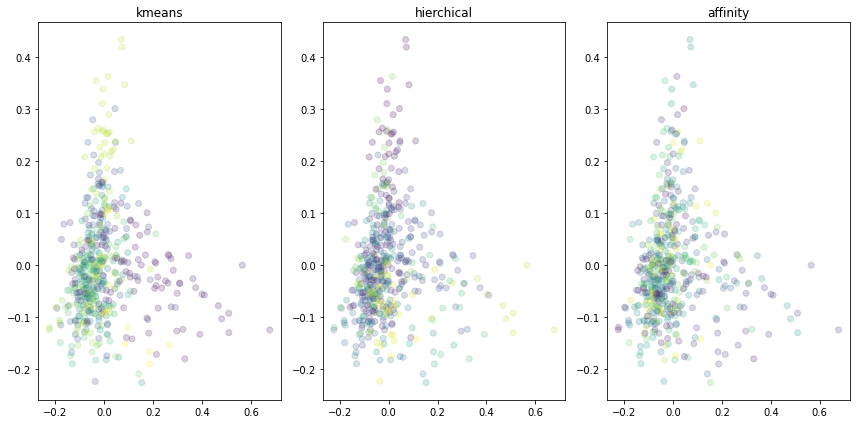

In [50]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=len(algorithms))
for i, (aname, assignment) in enumerate(assignments.items()):
    ax[i].scatter(Xpca[:,0], Xpca[:,1], c=assignment, alpha=.2)
    ax[i].set_title(aname)
plt.tight_layout()
plt.show()

In [52]:
def to_clusters(assignment):
    features = vectorizer.get_feature_names_out()
    clusters = defaultdict(list)
    for i, a in enumerate(assignment):
        row = X_train[:subset,:].toarray()[i]
        ingredients = [features[i] for i, x in enumerate(row) if x > 0]
        clusters[a].append(ingredients)
    return clusters

In [55]:
km_clusters = to_clusters(assignments['affinity'])
print(len(km_clusters))
for doc in km_clusters[1][:4]:
    print(doc)

80
['Mexican cheese blend', 'cooked chicken breasts', 'cooking spray', 'corn mix muffin', 'cream style corn', 'egg substitute', 'enchilada sauce', 'fat free milk', 'green chile', 'ground cumin', 'ground red pepper', 'non-fat sour cream']
['butter', 'cayenne pepper', 'celery', 'chicken broth', 'corn mix muffin', 'cream style corn', 'dried basil', 'dried oregano', 'dried thyme', 'eggs', 'garlic', 'green bell pepper', 'ground black pepper', 'milk', 'onions', 'plain yogurt', 'salt']
['clams', 'fat free milk', 'fettucine', 'fresh parsley', 'non-fat sour cream', 'pasta sauce', 'sliced mushrooms']


## Use LDA to reduce the dimensionality

In [56]:
from sklearn.decomposition import LatentDirichletAllocation

## Visualize the problem

In [57]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform(X_train.toarray())

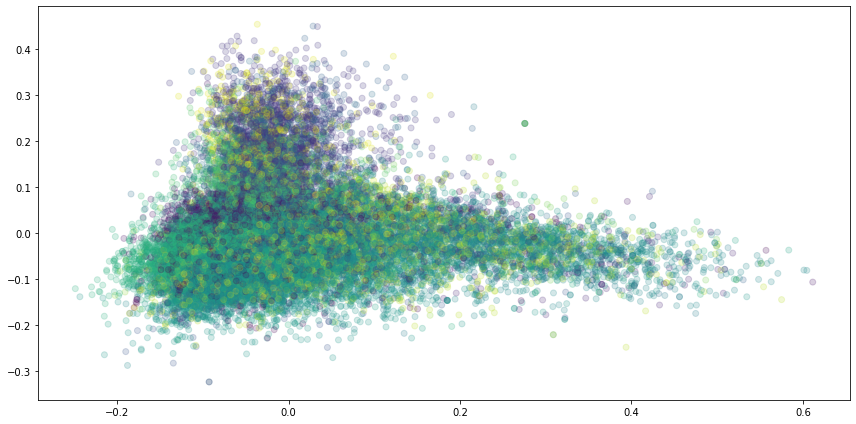

In [58]:
cuisines = list(set(y_train))
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(Xpca[:,0], Xpca[:,1], c=[cuisines.index(c) for c in y_train], alpha=.2)
plt.tight_layout()
plt.show()

## Test classifiers

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from bornrule import BornClassifier

In [60]:
classifiers = {
    'RAF': RandomForestClassifier(), 'LOR': LogisticRegression(max_iter=500), 'MNB': MultinomialNB(), 
    'SVC': SVC(), 'KNN': KNeighborsClassifier(), 'BORN': BornClassifier()
}

### Training

In [61]:
from sklearn.preprocessing import MinMaxScaler

In [62]:
X_train_s = X_train
X_test_s = X_test 

In [63]:
run = [(cname, cls) for cname, cls in classifiers.items()]
for cname, cls in tqdm(run):
    cls.fit(X_train_s, y_train)

  0%|          | 0/6 [00:00<?, ?it/s]

### Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
predictions = {}
for cname, cls in tqdm(run):
    predictions[cname] = cls.predict(X_test_s)

In [ ]:
results = {}
for cname, y_pred in predictions.items():
    clr = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    w = clr['weighted avg']
    m = clr['macro avg']
    results[cname] = {
        'w_precision': w['precision'], 'w_recall': w['recall'], 'w_f1': w['f1-score'],
        'm_precision': m['precision'], 'm_recall': m['recall'], 'm_f1': m['f1-score'],
    }
R = pd.DataFrame(results).T

In [ ]:
R.sort_values('w_f1', ascending=False)

## Explanation

In [ ]:
born = classifiers['BORN']

### Global

In [ ]:
global_e = pd.DataFrame(born.explain().toarray(), columns=born.classes_, index=vectorizer.get_feature_names_out())

In [ ]:
global_e['italian'].sort_values(ascending=False).head(10)

### Local

In [ ]:
local_docs = [['dry white wine', 'unsalted butter'], ['salt', 'rice vinegar', 'pesto', 'extra-virgin olive oil']]
local = vectorizer.transform(local_docs)

In [ ]:
P = pd.DataFrame(born.predict_proba(local), columns=born.classes_).T

In [ ]:
P.sort_values(1, ascending=False)

In [ ]:
E = pd.DataFrame(born.explain(X=local).toarray(), columns=born.classes_, index=vectorizer.get_feature_names_out())

In [ ]:
E['italian'].sort_values(ascending=False).head(10)

In [ ]:
E['japanese'].sort_values(ascending=False).head(10)